In [1]:
import pyspark
pyspark.__version__

'3.3.1'

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-diabetes').getOrCreate()
df = spark.read.csv('diabetes.csv', header = True, inferSchema = True)
df.printSchema()

23/02/18 13:38:01 WARN Utils: Your hostname, holly-virtual-machine resolves to a loopback address: 127.0.1.1; using 192.168.92.128 instead (on interface ens33)
23/02/18 13:38:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/18 13:38:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



In [3]:
import pandas as pd
pd.DataFrame(df.take(5), 
             columns=df.columns).transpose()

,0,1,2,3,4
Pregnancies,6.000,1.000,8.000,1.000,0.000
Glucose,148.000,85.000,183.000,89.000,137.000
BloodPressure,72.000,66.000,64.000,66.000,40.000
SkinThickness,35.000,29.000,0.000,23.000,35.000
Insulin,0.000,0.000,0.000,94.000,168.000
BMI,33.600,26.600,23.300,28.100,43.100
DiabetesPedigreeFunction,0.627,0.351,0.672,0.167,2.288
Age,50.000,31.000,32.000,21.000,33.000
Outcome,1.000,0.000,1.000,0.000,1.000


In [4]:
df.toPandas()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [5]:
df.groupby('Outcome').count().toPandas()

,Outcome,count
0,1,268
1,0,500


In [6]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features)\
      .describe()\
      .toPandas()\
      .transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Pregnancies,768,3.8450520833333335,3.36957806269887,0,17
Glucose,768,120.89453125,31.97261819513622,0,199
BloodPressure,768,69.10546875,19.355807170644777,0,122
SkinThickness,768,20.536458333333332,15.952217567727642,0,99
Insulin,768,79.79947916666667,115.24400235133803,0,846
Age,768,33.240885416666664,11.760231540678689,21,81
Outcome,768,0.3489583333333333,0.476951377242799,0,1


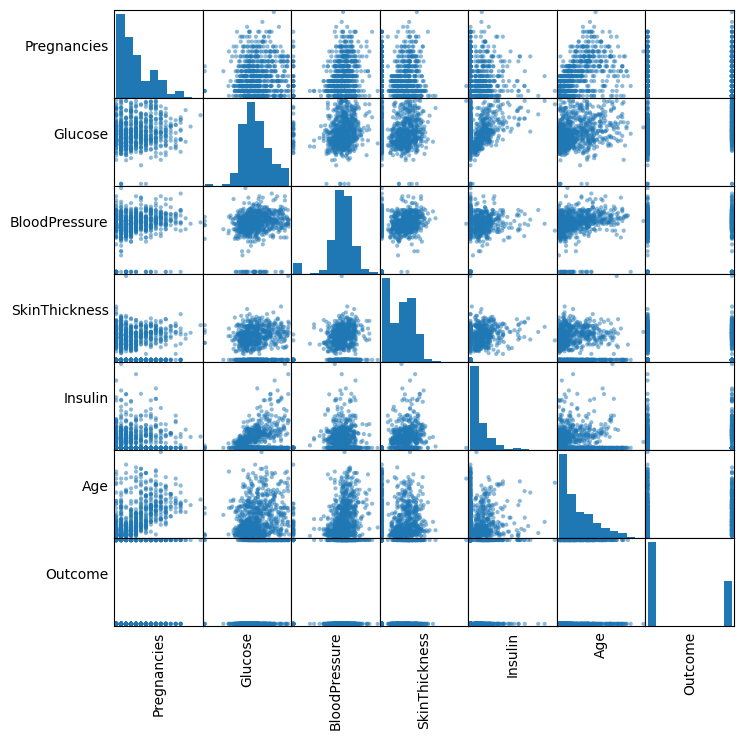

In [7]:
import matplotlib
from pandas.plotting import scatter_matrix
numeric_data = df.select(numeric_features).toPandas()
 
axs = scatter_matrix(numeric_data, figsize=(8, 8));
 
# Rotate axis labels and remove axis ticks
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [8]:
from pyspark.sql.functions import isnull, when, count, col
df.select([count(when(isnull(c), c)).alias(c)
           for c in df.columns]).show()

+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|          0|      0|            0|            0|      0|  0|                       0|  0|      0|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+



In [14]:

dataset = df.drop('SkinThickness')
dataset = df.drop('Insulin')
dataset = df.drop('DiabetesPedigreeFunction')
dataset = df.drop('Pregnancies')
 
dataset.show()

+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-------+-------------+-------------+-------+----+------------------------+---+-------+
|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|    116|           74|            0|      0|25.6|                   0.201| 30|      0|
|     78|           50|           32|     88|31.0|                   0.248| 26|      1|
|    115|            0|            0|      0|35.3|                   0.134| 29|      0|
|    197|           70|         

In [15]:
# 用VectorAssembler合并所有特性
required_features = ['Glucose',
                    'BloodPressure',
                    'BMI',
                    'Age']
 
from pyspark.ml.feature import VectorAssembler
 
assembler = VectorAssembler(
        inputCols=required_features, 
        outputCol='features')
 
transformed_data = assembler.transform(dataset)
transformed_data.show()

+-------+-------------+-------------+-------+----+------------------------+---+-------+--------------------+
|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|            features|
+-------+-------------+-------------+-------+----+------------------------+---+-------+--------------------+
|    148|           72|           35|      0|33.6|                   0.627| 50|      1|[148.0,72.0,33.6,...|
|     85|           66|           29|      0|26.6|                   0.351| 31|      0|[85.0,66.0,26.6,3...|
|    183|           64|            0|      0|23.3|                   0.672| 32|      1|[183.0,64.0,23.3,...|
|     89|           66|           23|     94|28.1|                   0.167| 21|      0|[89.0,66.0,28.1,2...|
|    137|           40|           35|    168|43.1|                   2.288| 33|      1|[137.0,40.0,43.1,...|
|    116|           74|            0|      0|25.6|                   0.201| 30|      0|[116.0,74.0,25.6,...|
|     78|          

In [16]:
(training_data, test_data) = transformed_data.randomSplit([0.8,0.2], seed =2020)
print("训练数据集总数: " + str(training_data.count()))
print("测试数据集总数: " + str(test_data.count()))

训练数据集总数: 620
测试数据集总数: 148


## 随机森林分类器

In [17]:
from pyspark.ml.classification import RandomForestClassifier
 
rf = RandomForestClassifier(labelCol='Outcome', 
                            featuresCol='features',
                            maxDepth=5)
model = rf.fit(training_data)
rf_predictions = model.transform(test_data)

In [18]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
 
multi_evaluator = MulticlassClassificationEvaluator(
      labelCol = 'Outcome', metricName = 'accuracy')
print('Random Forest classifier Accuracy:', multi_evaluator.evaluate(rf_predictions))

Random Forest classifier Accuracy: 0.7972972972972973


## 决策树分类器

In [19]:
from pyspark.ml.classification import DecisionTreeClassifier
 
dt = DecisionTreeClassifier(featuresCol = 'features',
                            labelCol = 'Outcome',
                            maxDepth = 3)
dtModel = dt.fit(training_data)
dt_predictions = dtModel.transform(test_data)
dt_predictions.select('Glucose', 'BloodPressure', 
                      'BMI', 'Age', 'Outcome').show(10)

+-------+-------------+----+---+-------+
|Glucose|BloodPressure| BMI|Age|Outcome|
+-------+-------------+----+---+-------+
|     57|           80|32.8| 41|      0|
|     67|           76|45.3| 46|      0|
|     71|           48|20.4| 22|      0|
|     71|           78|33.2| 21|      0|
|     72|           78|31.6| 38|      0|
|     76|           60|32.8| 41|      0|
|     78|           50|31.0| 26|      1|
|     78|           88|36.9| 21|      0|
|     84|           64|35.8| 21|      0|
|     84|           82|38.2| 23|      0|
+-------+-------------+----+---+-------+
only showing top 10 rows



In [20]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
 
multi_evaluator = MulticlassClassificationEvaluator(
      labelCol = 'Outcome', 
          metricName = 'accuracy')
print('Decision Tree Accuracy:', 
      multi_evaluator.evaluate(dt_predictions))

Decision Tree Accuracy: 0.7702702702702703


## 逻辑回归模型

In [21]:
from pyspark.ml.classification import LogisticRegression
 
lr = LogisticRegression(featuresCol = 'features', 
                        labelCol = 'Outcome', 
                        maxIter=10)
lrModel = lr.fit(training_data)
lr_predictions = lrModel.transform(test_data)

23/02/18 13:49:36 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/02/18 13:49:36 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [22]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
 
multi_evaluator = MulticlassClassificationEvaluator(
      labelCol = 'Outcome',
          metricName = 'accuracy')
print('Logistic Regression Accuracy:', 
      multi_evaluator.evaluate(lr_predictions))

Logistic Regression Accuracy: 0.7837837837837838


## 梯度提升树分类器模型

In [24]:
from pyspark.ml.classification import GBTClassifier
gb = GBTClassifier(
      labelCol = 'Outcome', 
      featuresCol = 'features')
gbModel = gb.fit(training_data)
gb_predictions = gbModel.transform(test_data)

In [25]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
multi_evaluator = MulticlassClassificationEvaluator(
        labelCol = 'Outcome',
        metricName = 'accuracy')
print('Gradient-boosted Trees Accuracy:',
      multi_evaluator.evaluate(gb_predictions))

Gradient-boosted Trees Accuracy: 0.7432432432432432
